In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LassoCV

from datetime import datetime


import warnings
warnings.filterwarnings("ignore")


In [2]:
import acquire as acq
import prepare as prep

from debug import local_settings, timeifdebug, timeargsifdebug, frame_splain, get_date_time_code
from acquire import get_telco_data
from prepare import DFO

In [3]:
local_settings.splain=True

In [4]:
local_settings.debug=True

In [5]:
splain = local_settings.splain
debug = local_settings.debug

In [6]:
    df = get_telco_data(splain=splain)
    df = df.set_index('customer_id')
    print(df.head(5))

get_telco_data () {'splain': True}
sql_df () {'sql': "\n    select\n        cust.`customer_id`,\n        cust.`gender`,\n        cust.`gender` = 'Male' is_male,\n        cust.`gender` = 'Female' is_female,\n        cust.`senior_citizen`,\n        cust.`partner` = 'Yes' partner,\n        cust.`dependents` = 'Yes' dependents,\n        cust.`partner` = 'Yes' or cust.`dependents` = 'Yes' family,\n        2 * case when cust.`partner` = 'Yes' then 1 else 0 end + case when cust.`dependents` = 'Yes' then 1 else 0 end partner_deps_id,\n        concat(\n            case when cust.`partner` = 'Yes' then 'Has ' else 'No ' end,\n            'partner, ',\n            case when cust.`dependents` = 'Yes' then 'has ' else 'no ' end,\n            'dependents') partner_deps,\n        cust.`tenure`,\n        (cust.`tenure` DIV 12) tenure_years,\n        case when cust.`contract_type_id` = 1 then 0 else (cust.`tenure` DIV case when cust.`contract_type_id` = 2 then 12 else 24 end) end contract_renews,\n    

In [7]:
df.head(5)

,gender,is_male,is_female,senior_citizen,partner,dependents,family,partner_deps_id,partner_deps,tenure,...,contract_duration,paperless_billing,payment_type_id,payment_type,auto_pay,manual_mtm,monthly_charges,total_charges,avg_monthly_variance,churn
customer_id,,,,,,,,,,,,,,,,,,,,,
0003-MKNFE,Male,1,0,0,0,0,0,0,"No partner, no dependents",9,...,1,0,2,Mailed check,0,1,59.9,542.40,0.37,0
0004-TLHLJ,Male,1,0,0,0,0,0,0,"No partner, no dependents",4,...,1,1,1,Electronic check,0,1,73.9,280.85,-3.69,1
0011-IGKFF,Male,1,0,1,1,0,1,2,"Has partner, no dependents",13,...,1,1,1,Electronic check,0,1,98.0,1237.85,-2.78,1
0013-EXCHZ,Female,0,1,1,1,0,1,2,"Has partner, no dependents",3,...,1,1,2,Mailed check,0,1,83.9,267.40,5.23,1
0013-MHZWF,Female,0,1,0,0,1,1,1,"No partner, has dependents",9,...,1,1,4,Credit card (automatic),1,0,69.4,571.45,-5.91,0


In [8]:
# df = dfo.df

In [9]:
@timeifdebug
def retype_cols(dataframe, columns, to_dtype, **kwargs):
    '''
    retype_cols(dataframe, columns, to_dtype, **kwargs)
    RETURNS dataframe with updated column types
    '''
    for col in (xcol for xcol in columns if xcol in dataframe.columns):
        dataframe[col] = dataframe[col].astype(to_dtype)
    
    # print(dataframe.dtypes)
    return dataframe

In [10]:
category_cols=[
    'partner_deps_id',
    'partner_deps',
    'gender',
    'contract_type_id',
    'internet_service_type_id',
    'internet_service_type',
    'contract_type',
    'payment_type_id',
    'payment_type',
    'phone_service_type',
    'phone_service_id'
]

category_cols

['partner_deps_id',
 'partner_deps',
 'gender',
 'contract_type_id',
 'internet_service_type_id',
 'internet_service_type',
 'contract_type',
 'payment_type_id',
 'payment_type',
 'phone_service_type',
 'phone_service_id']

In [11]:
df = retype_cols(dataframe=df, columns=category_cols, to_dtype='category')   
print(df.dtypes)

starting retype_cols
ending retype_cols ; time: 0.053442955017089844
gender                      category
is_male                        int64
is_female                      int64
senior_citizen                 int64
partner                        int64
dependents                     int64
family                         int64
partner_deps_id             category
partner_deps                category
tenure                         int64
tenure_years                   int64
contract_renews                int64
remaining_months               int64
thru_first_month               int64
thru_first_quarter             int64
thru_first_year                int64
thru_first_term                int64
phone_service                  int64
multiple_lines                 int64
phone_service_id            category
phone_service_type          category
internet_service_type_id    category
internet_service_type       category
internet_service               int64
has_dsl                        int64
has_fi

In [12]:
boolean_cols  = [
    'is_male',
    'is_female',
    'senior_citizen',
    'partner',
    'dependents',
    'family',
    'thru_first_month',
    'thru_first_quarter',
    'thru_first_year',
    'thru_first_term',
    'phone_service',
    'multiple_lines',
    'internet_service',
    'has_dsl',
    'has_fiber',
    'online_security',
    'online_backup',
    'online_security_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies',
    'streaming_services',
    'streaming_dsl',
    'streaming_fiber',
    'on_contract',
    'paperless_billing',
    'manual_mtm',
    'auto_pay'
]

boolean_cols

['is_male',
 'is_female',
 'senior_citizen',
 'partner',
 'dependents',
 'family',
 'thru_first_month',
 'thru_first_quarter',
 'thru_first_year',
 'thru_first_term',
 'phone_service',
 'multiple_lines',
 'internet_service',
 'has_dsl',
 'has_fiber',
 'online_security',
 'online_backup',
 'online_security_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'streaming_services',
 'streaming_dsl',
 'streaming_fiber',
 'on_contract',
 'paperless_billing',
 'manual_mtm',
 'auto_pay']

In [13]:
df = retype_cols(dataframe=df, columns=boolean_cols, to_dtype='bool')
print(df.dtypes)

starting retype_cols
ending retype_cols ; time: 0.050360918045043945
gender                      category
is_male                         bool
is_female                       bool
senior_citizen                  bool
partner                         bool
dependents                      bool
family                          bool
partner_deps_id             category
partner_deps                category
tenure                         int64
tenure_years                   int64
contract_renews                int64
remaining_months               int64
thru_first_month                bool
thru_first_quarter              bool
thru_first_year                 bool
thru_first_term                 bool
phone_service                   bool
multiple_lines                  bool
phone_service_id            category
phone_service_type          category
internet_service_type_id    category
internet_service_type       category
internet_service                bool
has_dsl                         bool
has_fi

In [14]:
string_cols = [
    'partner_deps',
    'gender',
    'internet_service_type',
    'contract_type',
    'payment_type',
    'phone_service_type',
]

string_cols

['partner_deps',
 'gender',
 'internet_service_type',
 'contract_type',
 'payment_type',
 'phone_service_type']

In [15]:
dfo = prep.set_dfo(dfo_df=df, y_column='churn', splain=True)

starting set_dfo
ending set_dfo ; time: 1.0013580322265625e-05


In [16]:
# dfo.df = df

In [17]:
frame_splain(dfo.df, splain=True)

starting frame_splain
DATAFRAME SHAPE:
(7043, 49) 

DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0003-MKNFE to 9995-HOTOH
Data columns (total 49 columns):
gender                      7043 non-null category
is_male                     7043 non-null bool
is_female                   7043 non-null bool
senior_citizen              7043 non-null bool
partner                     7043 non-null bool
dependents                  7043 non-null bool
family                      7043 non-null bool
partner_deps_id             7043 non-null category
partner_deps                7043 non-null category
tenure                      7043 non-null int64
tenure_years                7043 non-null int64
contract_renews             7043 non-null int64
remaining_months            7043 non-null int64
thru_first_month            7043 non-null bool
thru_first_quarter          7043 non-null bool
thru_first_year             7043 non-null bool
thru_first_term             7043 non-null bool


starting heatmap_train


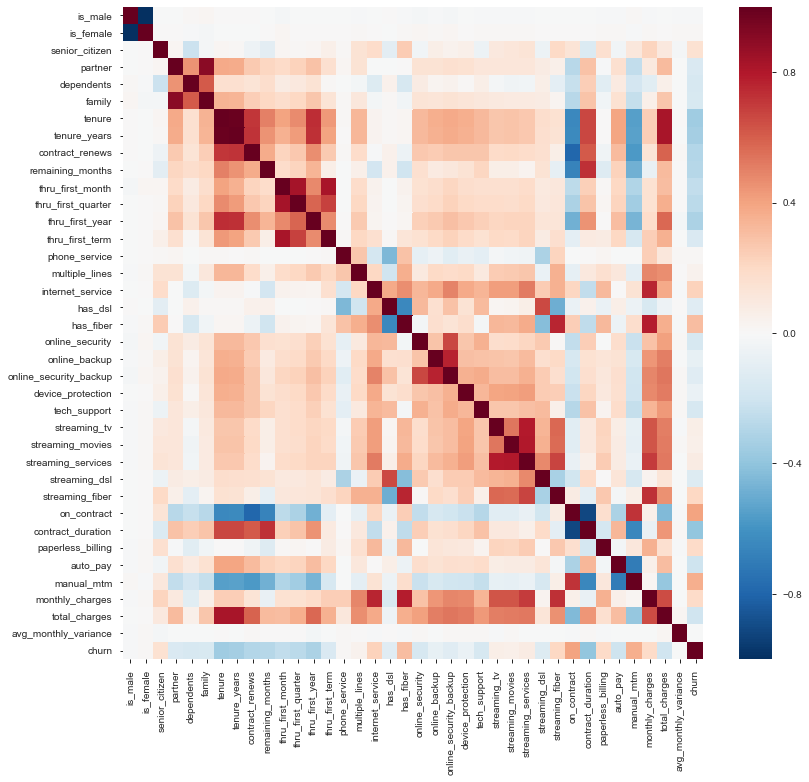

ending heatmap_train ; time: 0.8672959804534912


In [18]:
prep.heatmap_train(df, show_now=True, annot=False)

In [19]:
# prep.pairplot_train(df, show_now=True)

In [20]:
df[df.tenure == 0]

,gender,is_male,is_female,senior_citizen,partner,dependents,family,partner_deps_id,partner_deps,tenure,...,contract_duration,paperless_billing,payment_type_id,payment_type,auto_pay,manual_mtm,monthly_charges,total_charges,avg_monthly_variance,churn
customer_id,,,,,,,,,,,,,,,,,,,,,
1371-DWPAZ,Female,False,True,False,True,True,True,3,"Has partner, has dependents",0,...,24,False,4,Credit card (automatic),True,False,56.05,0.0,0.0,0
2923-ARZLG,Male,True,False,False,True,True,True,3,"Has partner, has dependents",0,...,12,True,2,Mailed check,False,False,19.70,0.0,0.0,0
2520-SGTTA,Female,False,True,False,True,True,True,3,"Has partner, has dependents",0,...,24,False,2,Mailed check,False,False,20.00,0.0,0.0,0
2775-SEFEE,Male,True,False,False,False,True,True,1,"No partner, has dependents",0,...,24,True,3,Bank transfer (automatic),True,False,61.90,0.0,0.0,0
3115-CZMZD,Male,True,False,False,False,True,True,1,"No partner, has dependents",0,...,24,False,2,Mailed check,False,False,20.25,0.0,0.0,0
3213-VVOLG,Male,True,False,False,True,True,True,3,"Has partner, has dependents",0,...,24,False,2,Mailed check,False,False,25.35,0.0,0.0,0
4075-WKNIU,Female,False,True,False,True,True,True,3,"Has partner, has dependents",0,...,24,False,2,Mailed check,False,False,73.35,0.0,0.0,0
4367-NUYAO,Male,True,False,False,True,True,True,3,"Has partner, has dependents",0,...,24,False,2,Mailed check,False,False,25.75,0.0,0.0,0
4472-LVYGI,Female,False,True,False,True,True,True,3,"Has partner, has dependents",0,...,24,True,3,Bank transfer (automatic),True,False,52.55,0.0,0.0,0


In [21]:
@timeifdebug
def drop_cols(df, cols, **kwargs):
    '''
    drop_cols(dataframe, columns, **kwargs)
    RETURNS dataframe with columns removed
    
    Function first checks to ensure columns are in dataframe.
    '''
    dropcols = [col for col in cols if col in df.columns]
    if len(dropcols):
        df = df.drop(columns=dropcols)    
    return df

In [22]:
# df2 = acq.check_df(dfo.train)
# df2 is df

In [23]:
# df2 = drop_cols(df=df2, cols=string_cols)
# frame_splain(df2, splain=True)

In [24]:
dfo = prep.split_dfo(dfo, train_pct=.7, randomer=123456789, stratify=dfo.y_column, drop_cols=string_cols, splain=local_settings.splain)

starting split_dfo
starting remove_cols
ending remove_cols ; time: 0.0016787052154541016
starting split_my_data_whole
ending split_my_data_whole ; time: 0.00799417495727539
starting frame_splain
DFO TRAIN SHAPE:
(5282, 43) 

DFO TRAIN INFO:
<class 'pandas.core.frame.DataFrame'>
Index: 5282 entries, 5138-WVKYJ to 5816-QVHRX
Data columns (total 43 columns):
is_male                     5282 non-null bool
is_female                   5282 non-null bool
senior_citizen              5282 non-null bool
partner                     5282 non-null bool
dependents                  5282 non-null bool
family                      5282 non-null bool
partner_deps_id             5282 non-null category
tenure                      5282 non-null int64
tenure_years                5282 non-null int64
contract_renews             5282 non-null int64
remaining_months            5282 non-null int64
thru_first_month            5282 non-null bool
thru_first_quarter          5282 non-null bool
thru_first_year        

In [25]:
dfo = prep.scale_dfo(dfo, scaler_fn=None, splain=splain)

starting scale_dfo
starting xy_df
starting frame_splain
ending frame_splain ; time: 1.0967254638671875e-05
starting frame_splain
ending frame_splain ; time: 8.821487426757812e-06
ending xy_df ; time: 0.003309011459350586
starting xy_df
starting frame_splain
ending frame_splain ; time: 9.059906005859375e-06
starting frame_splain
ending frame_splain ; time: 8.106231689453125e-06
ending xy_df ; time: 0.0025892257690429688
starting frame_splain
X_TRAIN SHAPE:
(5282, 43) 

X_TRAIN INFO:
<class 'pandas.core.frame.DataFrame'>
Index: 5282 entries, 5138-WVKYJ to 5816-QVHRX
Data columns (total 43 columns):
is_male                     5282 non-null bool
is_female                   5282 non-null bool
senior_citizen              5282 non-null bool
partner                     5282 non-null bool
dependents                  5282 non-null bool
family                      5282 non-null bool
partner_deps_id             5282 non-null category
tenure                      5282 non-null int64
tenure_years   

In [26]:
X_train = dfo.X_train
y_train = dfo.y_train
X_test = dfo.X_test
y_test = dfo.y_test

In [27]:
cor = dfo.df.corr()


In [28]:
y_cor = pd.DataFrame(cor.loc[:,dfo.y_column])

In [29]:
y_cor['abs_r']=abs(y_cor[dfo.y_column])
y_cor.sort_values(by='abs_r', ascending=False)

,churn,abs_r
churn,1.000000,1.000000
on_contract,0.405103,0.405103
contract_duration,-0.394453,0.394453
manual_mtm,0.361447,0.361447
tenure,-0.352229,0.352229
tenure_years,-0.342196,0.342196
thru_first_year,-0.317666,0.317666
has_fiber,0.308020,0.308020
contract_renews,-0.296325,0.296325
remaining_months,-0.282893,0.282893


In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

from sklearn.ensemble import RandomForestClassifier


## Decision Tree

In [31]:
# for classification you can change the algorithm to gini or entropy (information gain).  Default is gini.
dtc = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=4, 
    min_samples_leaf=5, 
    min_samples_split=10,
    random_state=dfo.randomer, 
    # max_features=len(dfo.train.columns)-1
    max_features=15
)


In [32]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=15, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123456789, splitter='best')

In [33]:
y_pred_dtc_tr = dtc.predict(X_train)
y_pred_dtc_tr_proba = dtc.predict_proba(X_train)
y_pred_dtc_tr_proba

array([[0.28089888, 0.71910112],
       [0.75252525, 0.24747475],
       [0.48722986, 0.51277014],
       ...,
       [0.96963563, 0.03036437],
       [0.64455782, 0.35544218],
       [0.6635514 , 0.3364486 ]])

In [34]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(dtc.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(dtc.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 0.78
Accuracy of Decision Tree classifier on test set: 0.78


In [35]:
confusion_matrix(y_train, y_pred_dtc_tr)

array([[3299,  558],
       [ 609,  816]])

In [36]:
print(classification_report(y_train, y_pred_dtc_tr))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      3857
           1       0.59      0.57      0.58      1425

    accuracy                           0.78      5282
   macro avg       0.72      0.71      0.72      5282
weighted avg       0.78      0.78      0.78      5282



In [37]:
recall_score(y_train, y_pred_dtc_tr)

0.5726315789473684

In [38]:
y_pred_dtc_ts = dtc.predict(X_test)
y_pred_dtc_ts_proba = dtc.predict_proba(X_test)
y_pred_dtc_ts_proba

array([[0.98728814, 0.01271186],
       [0.84788732, 0.15211268],
       [0.98728814, 0.01271186],
       ...,
       [0.28089888, 0.71910112],
       [0.90909091, 0.09090909],
       [0.64455782, 0.35544218]])

In [39]:
print(classification_report(y_test, y_pred_dtc_ts))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1317
           1       0.55      0.58      0.57       444

    accuracy                           0.78      1761
   macro avg       0.71      0.71      0.71      1761
weighted avg       0.78      0.78      0.78      1761



In [40]:
confusion_matrix(y_test, y_pred_dtc_ts)

array([[1108,  209],
       [ 185,  259]])

In [41]:
recall_score(y_test, y_pred_dtc_ts)

0.5833333333333334

## *Optimize for recall*

## Recall = False Negatives = *surprise dollars lost*

In [42]:
col_vital_dtc = pd.DataFrame(X_train.columns, columns=['column'])
col_vital_dtc['importance'] = dtc.feature_importances_
col_vital_dtc.sort_values(by='importance', ascending=False)

,column,importance
34,contract_duration,0.630783
31,streaming_fiber,0.121945
13,thru_first_year,0.064781
21,has_fiber,0.062068
7,tenure,0.031854
36,payment_type_id,0.018679
30,streaming_dsl,0.015840
32,contract_type_id,0.015288
8,tenure_years,0.014176
41,avg_monthly_variance,0.012828


In [43]:
def get_date_time_code(datetime=datetime.now(), in_format='%Y%d%m%H%M'):
    return datetime.strftime(in_format)



In [44]:
import graphviz

from graphviz import Graph

dot_data = export_graphviz(dtc, out_file=None) 
graph = graphviz.Source(dot_data) 
file_name = 'telco_churn_decision_tree_' + get_date_time_code()
graph.render(file_name , view=True)

'telco_churn_decision_tree_201929101724.pdf'

## Random Forest

In [45]:
rfc = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=5,
                            n_estimators=10000,
                            max_depth=None, 
                            random_state=dfo.randomer)

rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=None, oob_score=False, random_state=123456789,
                       verbose=0, warm_start=False)

In [46]:
y_pred_rfc_tr = rfc.predict(X_train)
y_pred_rfc_tr_proba_ = rfc.predict_proba(X_train)
y_pred_rfc_tr_proba_

array([[0.3535174 , 0.6464826 ],
       [0.7578543 , 0.2421457 ],
       [0.70346448, 0.29653552],
       ...,
       [0.95221402, 0.04778598],
       [0.75209784, 0.24790216],
       [0.66296798, 0.33703202]])

In [47]:
y_pred_rfc_ts = rfc.predict(X_test)
y_pred_rfc_ts_proba_ = rfc.predict_proba(X_test)
y_pred_rfc_ts_proba_

array([[0.98840271, 0.01159729],
       [0.93631386, 0.06368614],
       [0.98808776, 0.01191224],
       ...,
       [0.34328993, 0.65671007],
       [0.97186258, 0.02813742],
       [0.58151174, 0.41848826]])

In [48]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rfc.score(X_train, y_train)))
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rfc.score(X_test, y_test)))

Accuracy of random forest classifier on training set: 0.87
Accuracy of random forest classifier on test set: 0.81


In [49]:
confusion_matrix(y_train, y_pred_rfc_tr)

array([[3663,  194],
       [ 498,  927]])

In [50]:
print(classification_report(y_train, y_pred_rfc_tr))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      3857
           1       0.83      0.65      0.73      1425

    accuracy                           0.87      5282
   macro avg       0.85      0.80      0.82      5282
weighted avg       0.87      0.87      0.86      5282



In [51]:
print(classification_report(y_test, y_pred_rfc_ts))

              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1317
           1       0.66      0.50      0.57       444

    accuracy                           0.81      1761
   macro avg       0.75      0.70      0.72      1761
weighted avg       0.80      0.81      0.80      1761



In [52]:
confusion_matrix(y_test, y_pred_rfc_ts)

array([[1201,  116],
       [ 223,  221]])

In [53]:
col_imps_rfc = pd.DataFrame(X_train.columns, columns=['column'])
col_imps_rfc['importance'] = rfc.feature_importances_
col_imps_rfc.sort_values(by='importance', ascending=False)

,column,importance
39,monthly_charges,0.091978
7,tenure,0.084693
40,total_charges,0.083963
34,contract_duration,0.058999
32,contract_type_id,0.058340
41,avg_monthly_variance,0.055357
33,on_contract,0.054621
21,has_fiber,0.041707
9,contract_renews,0.037948
36,payment_type_id,0.035321


In [54]:
from datetime import datetime
from datetime import date

now = datetime.now() # current date and time
# now = date(2004, 1, 4)
year = now.strftime("%Y")
# print("year:", year)
month = now.strftime("%m")
# print("month:", month)
day = now.strftime("%d")
# print("day:", day)
time = now.strftime("%H:%M:%S")
# print("time:", time)
date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
# print("date and time:",date_time)
date_code = now.strftime('%Y%d%m%H%M')
print('date string:', date_code)

date string: 201929101725


In [58]:
from math import sqrt
from scipy import stats

In [78]:
a = .05
p_list = []
col_name = dfo.y_column
for col in boolean_cols:
    is_true = dfo.train[dfo.train[col] == True]
    y_if_true = is_true[col_name].mean()
    y_mean = dfo.train[col_name].mean()
    t, p = stats.ttest_1samp(is_true.churn, df.churn.mean())
    
    p_list.append([col, t, p, p<a, y_if_true, y_mean])


df_p = pd.DataFrame(p_list, columns=['column','t_stat','p_value','is_sig', col_name + '_if_true', col_name + '_mean']).set_index('column').sort_values(by='p_value')
df_p

,t_stat,p_value,is_sig,churn_if_true,churn_mean
column,,,,,
manual_mtm,18.775176,9.808481e-73,True,0.471671,0.269784
on_contract,18.267773,1.049569e-70,True,0.432212,0.269784
has_fiber,15.374550,7.024343e-51,True,0.422747,0.269784
thru_first_year,-14.208909,1.172701e-44,True,0.176455,0.269784
auto_pay,-13.284508,7.315771e-39,True,0.163203,0.269784
online_security,-12.552510,1.982200e-34,True,0.149464,0.269784
dependents,-11.952861,1.459330e-31,True,0.155384,0.269784
tech_support,-11.666832,3.433328e-30,True,0.156863,0.269784
streaming_fiber,11.471346,2.445829e-29,True,0.405707,0.269784


In [76]:
#     stats.ttest_ind(x1, x2)
a = .05
col_name = dfo.y_column
p_list2 = []
for col in boolean_cols:
    is_true = dfo.train[dfo.train[col] == True][col_name]
    is_not = dfo.train[dfo.train[col] != True][col_name]
    y_if_true = is_true.mean()
    y_if_not = is_not.mean()
    t, p = stats.ttest_ind(is_true, is_not)
    
    p_list2.append([col, t, p, p<a, y_if_true, y_if_not])

df_p2 = pd.DataFrame(p_list2, columns=['column','t_stat','p_value','is_sig', col_name + '_if_true', col_name + '_if_not']).set_index('column').sort_values(by='p_value')
df_p2

,t_stat,p_value,is_sig,churn_if_true,churn_if_not
column,,,,,
on_contract,32.711004,7.178696e-214,True,0.432212,0.065413
manual_mtm,28.435881,1.276718e-165,True,0.471671,0.140193
thru_first_year,-24.827473,8.583005e-129,True,0.176455,0.490446
has_fiber,23.370213,4.971554e-115,True,0.422747,0.149051
thru_first_quarter,-20.874036,4.827529e-93,True,0.223877,0.596923
thru_first_month,-18.681179,1.823876e-75,True,0.235245,0.623404
internet_service,17.475922,1.580964e-66,True,0.324842,0.074138
auto_pay,-15.739837,1.381969e-54,True,0.163203,0.352624
streaming_fiber,15.061211,3.179441e-50,True,0.405707,0.210082


## Churn Rates by Tenure

In [182]:
def cumulative_target_analysis(
    df, 
    target_col='target', 
    feature_cal='feature', 
    target_val=True, 
    target_val_str='true',
    idx_numeric=True,
    **kwargs
):
    target_col = dfo.y_column
    target_val = True
    target_val_str = 'true'
    feature_col = 'tenure'
    use_df = dfo.train
    tot_custs = len(use_df)
    target_feature_label = feature_col + '_' + target_col + '_is_' + target_val_str
    total_feature_label = feature_col + '_count'
    eligible_feature_label = feature_col + '_eligible_count'
    eligible_rate_label = feature_col + '_' + target_col + '_rate'
    cumulative_target_label = 'cumulative_' + target_col + '_is_' + target_val_str
    cumulative_rate_label = 'cumulative_' + target_col + '_rate'

    true_df = use_df[use_df[target_col] == target_val]

    target_vals = (true_df[feature_col]
                 .value_counts()
                 .reset_index()
                 .rename(columns={feature_col: target_feature_label})
                 .rename(columns={'index': feature_col})
                .sort_values(by=feature_col)
                )

    eligible_vals = (use_df[feature_col]
                .value_counts()
                .reset_index()
                .rename(columns={feature_col: eligible_feature_label})
                .rename(columns={'index': feature_col})
                .sort_values(by=feature_col)
               )
    
    if idx_numeric:
        eligible_max = use_df[feature_col].max()
        master_df = pd.DataFrame(np.arange(eligible_max + 1), columns=[feature_col])
        merge_df = (pd
                   .merge(master_df, eligible_vals, on=feature_col, how='left')
                   .fillna(value=0)
                   .astype('int64')
                   .sort_values(by=feature_col)
                   .set_index(feature_col))
    else:
        merge_df = eligible_vals
    

    merge_df = (pd
               .merge(merge_df, target_vals, on=feature_col, how='left')
               .fillna(value=0)
               .astype('int64')
               .sort_values(by=feature_col)
               .set_index(feature_col))

    merge_df = merge_df[[target_feature_label, eligible_feature_label]]

    tot_pop = []
    cur_pop = tot_custs

    for mo in merge_df[eligible_feature_label]:
        tot_pop.append(cur_pop)
        cur_pop -= mo

    tot_true = []
    tot_trues = 0    
    for mo in merge_df[target_feature_label]:
        tot_trues += mo
        tot_true.append(tot_trues)

    merge_df[eligible_feature_label] = tot_pop
    merge_df[eligible_rate_label] = merge_df[target_feature_label] / merge_df[eligible_feature_label]
    merge_df[cumulative_target_label] = tot_true
    merge_df[cumulative_rate_label] = merge_df[cumulative_target_label] / tot_custs
    return merge_df



# tenure_churns = dfo.train[dfo.train.]

In [184]:
cumulative_target_analysis(
    df=dfo.train, 
    target_col=dfo.y_column, 
    feature_cal='tenure', 
    target_val=True, 
    target_val_str='true',
    idx_numeric=False)

,tenure_churn_is_true,tenure_eligible_count,tenure_churn_rate,cumulative_churn_is_true,cumulative_churn_rate
tenure,,,,,
0,0,5282,0.000000,0,0.000000
1,293,5277,0.055524,293,0.055471
2,95,4812,0.019742,388,0.073457
3,69,4632,0.014896,457,0.086520
4,64,4477,0.014295,521,0.098637
5,50,4343,0.011513,571,0.108103
6,30,4242,0.007072,601,0.113783
7,38,4161,0.009132,639,0.120977
8,34,4054,0.008387,673,0.127414
